In [2]:
import perceval as pcvl
import numpy as np
import sympy as sp

## Use the symbolic skin for display
from perceval.rendering.circuit import DisplayConfig, SymbSkin
from perceval.rendering.format import Format
DisplayConfig.select_skin(SymbSkin)

### Circuit functions - old

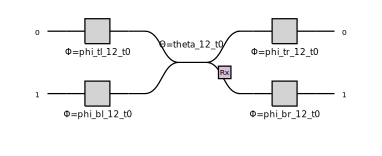

In [72]:
def U_ij_t(i : int , j : int, t : int = 0):
    """Returns the unitary acting on mode i and j."""
    return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
            .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))

U_12 = U_ij_t(1, 2)
pcvl.pdisplay(U_12)

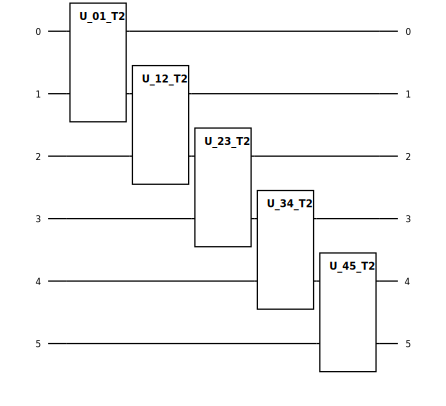

In [13]:
def full_layer(n : int, t : int = 0, _overlapping : bool = False):
    layer = pcvl.Circuit(n)
    if _overlapping:
        for i in range(n-1):
            layer = layer.add(i, U_ij_t(i, (i+1), t))
    else:
        if n % 2 != 0:
            print("WARNING: The number is not even and _overlapping is False => the last mode will be ignored.")
        for i in range((n)//2):
            layer = layer.add(2*i, U_ij_t(i, i+1, t))
    return layer

layer = full_layer(6, 2, True)
pcvl.pdisplay(layer)

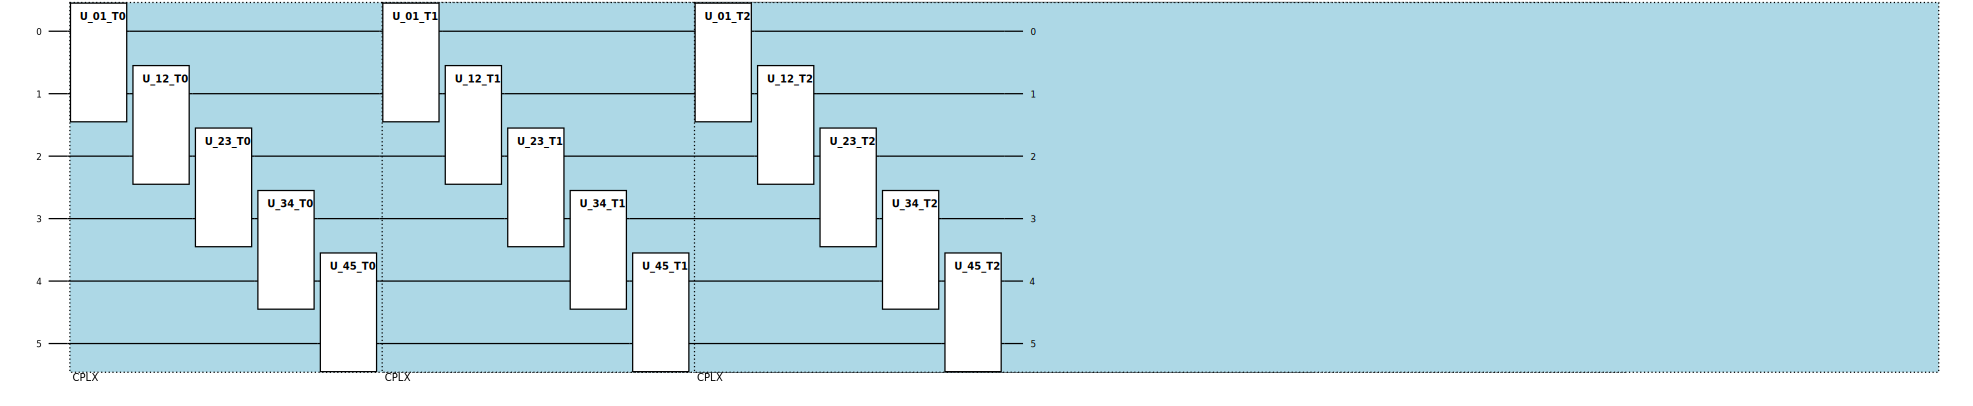

In [14]:
def create_circuit(n, t, _overlapping=False):
    main_circuit = pcvl.Circuit(n)
    for t in range(t):
        main_circuit = main_circuit.add(0, full_layer(n, t, _overlapping), merge=False)
    return main_circuit

# Example usage:
n = 6  # Number of modes
t = 3  # Number of times to repeat the layers
circuit = create_circuit(n, t, _overlapping=True)
pcvl.pdisplay(circuit, recursive=True)

### Imperfect Case - constant loss for each channel

Implemented the circuit with lossy channels, reused some code

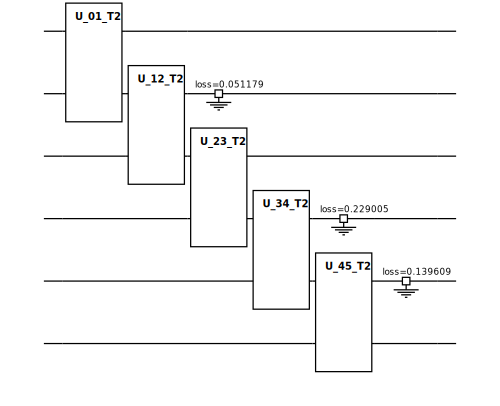

In [99]:
def generate_gaussian_0_1(mean, std_dev, num_samples):
    """
    Generate Gaussian samples on the interval [0,1].

    :param mean: The mean of the Gaussian distribution.
    :param std_dev: The standard deviation of the Gaussian distribution.
    :param num_samples: The number of samples to generate.
    """
    samples = []
    while len(samples) < num_samples:
        sample = np.random.normal(mean, std_dev)
        if sample >= 0 and sample <= 1:
            samples.append(sample)
    return np.array(samples)

def full_layer_loss(m : int, t : int = 0, _overlapping : bool = False, noise_mean : float = 0.1, noise_std : float = 0.2, noise_modes=[]):
    """
    Generates a full layer with loss.
    """
    layer = pcvl.Processor("SLOS", m, source=pcvl.Source(emission_probability=.6, multiphoton_component=.01))
    if _overlapping:
        for i in range(m-1):
            layer = layer.add(i, U_ij_t(i, (i+1), t))
    else:
        if m % 2 != 0:
            print("WARNING: The number is not even and _overlapping is False => the last mode will be ignored.")
        for i in range((m)//2):
            layer = layer.add(2*i, U_ij_t(i, i+1, t))
    if len(noise_modes) != 0:
        random_noise = generate_gaussian_0_1(noise_mean, noise_std, len(noise_modes))
        for i in range(len(noise_modes)):
            layer.add(int(noise_modes[i]), pcvl.LC(random_noise[i]), keep_port=True)
    return layer

layer_noisy = full_layer_loss(6, 2, True, noise_mean=0.1, noise_std=0.1, noise_modes=[1,3,4])
pcvl.pdisplay(layer_noisy)

[1, 3, 4]


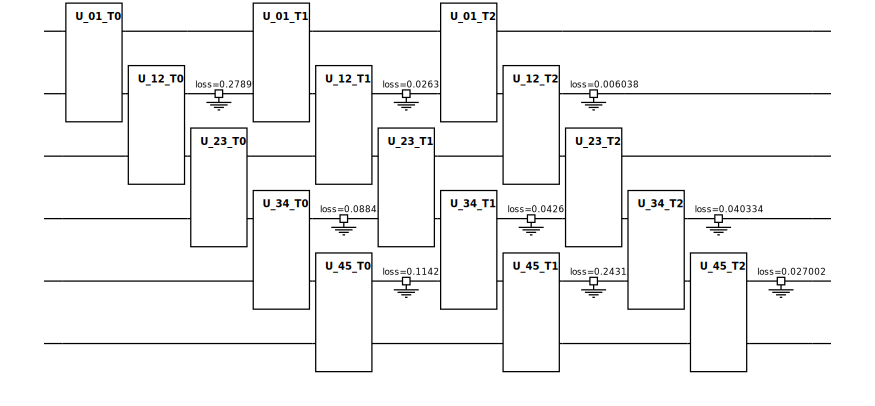

In [102]:
def create_circuit(m, t, _overlapping=False, noise_mean=0.1, noise_std=0.1, noise_modes=[]):
    main_circuit = pcvl.Processor(m, source=pcvl.Source(emission_probability=.6, multiphoton_component=.01))
    print(noise_modes)
    for t in range(t):
        main_circuit = main_circuit.add(0, full_layer_loss(m, t, _overlapping, noise_mean, noise_std, noise_modes))
    return main_circuit

# Example usage:
n = 6  # Number of modes
t = 3  # Number of times to repeat the layers
circuit = create_circuit(n, t, _overlapping=True, noise_mean=0.1, noise_std=0.1, noise_modes=[1,3,4])
pcvl.pdisplay(circuit)